In [4]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [5]:
from pathlib import Path

import polars as pl

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import prepare_data
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_performance import (
    get_confusion_matrix,
    get_model_predictions,
    plot_pr_curve,
    plot_roc_curve,
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
configure_logging(stream=False)

In [6]:
# Load model
model, features, sample_length = load_model(
    "results/experiment_eda_phasic_eda_tonic/model/PatchTST_20250519-172911.pt"
)

# Load data from database
db = DatabaseManager()
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

# Prepare data
X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df, features, sample_length, RANDOM_SEED
)

train_val_loader, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)


In [7]:
probs, y_true = get_model_predictions(
    model,
    test_loader,
)

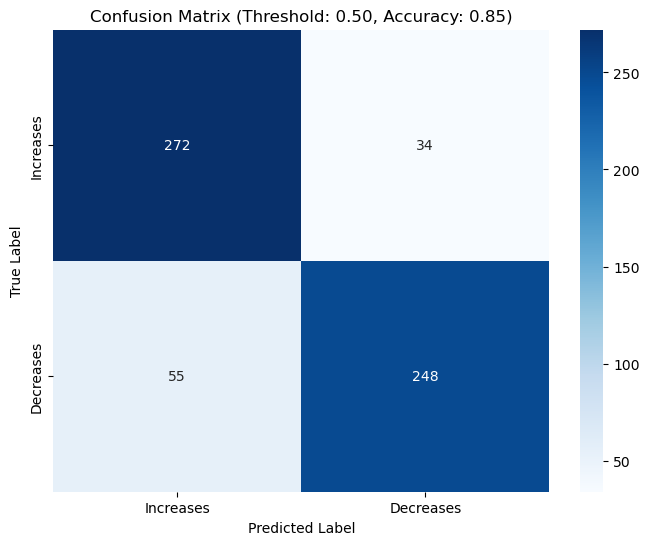

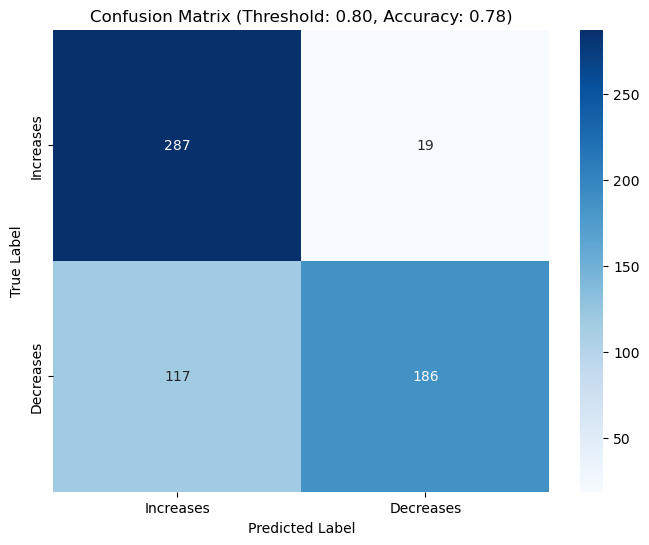

In [8]:
conf_matrix = get_confusion_matrix(probs, y_true, threshold=0.5)
conf_matrix = get_confusion_matrix(probs, y_true, threshold=0.8)

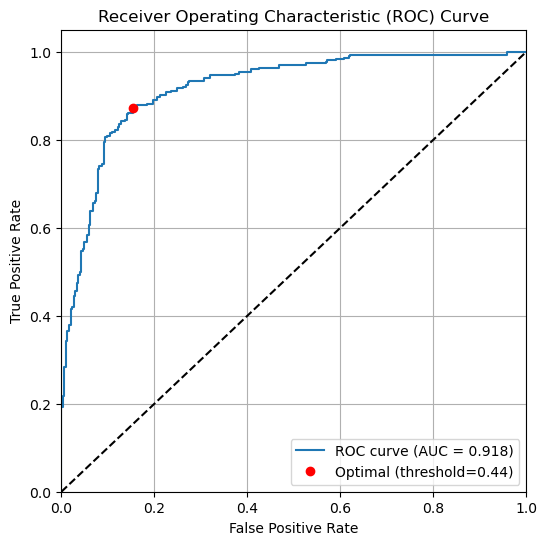

In [9]:
plot_roc_curve(probs, y_true)

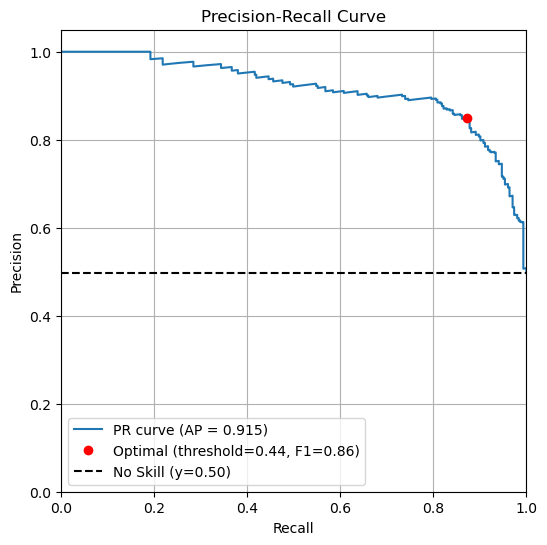

In [10]:
ap_score, optimal_pr_threshold = plot_pr_curve(probs, y_true)  # ap = average precision